In [1]:
import os
import numpy as np
import time
import copy
import sys
import re

import scipy.io

import matplotlib
import matplotlib.pyplot as plt

ang_2_bohr = 1.0/0.52917721067
hart_2_ev = 27.21138602

import atomistic_tools.cp2k_stm_utilities as csu

In [2]:
folder = "./test/water/"
file_basis_set = folder + "BASIS_MOLOPT"
file_xyz = folder + "water.xyz"
file_restart = folder + "cp2k-RESTART.wfn"
file_cp2k_inp = folder + "water_PBE.inp"

In [29]:
emin = -100.0
emax =  100.0

time1 = time.time()
elem_basis_names, cell = csu.read_cp2k_input(file_cp2k_inp)
print("Read cp2k input: %.3f" % (time.time()-time1))

time1 = time.time()
basis_sets = csu.read_basis_functions(file_basis_set, elem_basis_names)
print("Read basis sets: %.3f" % (time.time()-time1))

time1 = time.time()
ase_atoms = csu.read_xyz(file_xyz)
csu.center_atoms_to_cell(ase_atoms.positions, cell/ang_2_bohr)
print("Read xyz: %.3f" % (time.time()-time1))

time1 = time.time()
morb_composition, morb_energies, morb_occs, homo_inds, ref_en = csu.load_restart_wfn_file(file_restart, emin, emax, 1, 1)
print("Found %d orbitals" % len(morb_energies[0]))
print("Read restart: %.3f" % (time.time()-time1))

Read cp2k input: 0.001
Read basis sets: 0.002
Read xyz: 0.001
R1/1, loading indexes 4:7 / 0:3
Found 0 orbitals
Read restart: 0.002


In [30]:
# Define real space grid
# Cp2k chooses close to 0.08 angstroms (?)
step = 0.2 # Good to choose a factor of the lattice parameter 4.26
step *= ang_2_bohr
cell_n = (np.round(cell/step)).astype(int)

# Other possiblity: define cell_n directly
#cell_n = np.array([75, 75, 75])

In [9]:
cell_n

array([50, 50, 50])

In [10]:
# define evaluation region:

x_eval_region = None
y_eval_region = None
z_eval_region = None

eval_regions = [x_eval_region, y_eval_region, z_eval_region]

origin = np.zeros(3)
new_cell = np.copy(cell)

for i, e_reg in enumerate(eval_regions):
    if e_reg is None:
        origin[i] = 0.0
        new_cell[i] = cell[i]
    else:
        origin[i] = e_reg[0]
        new_cell[i] = e_reg[1] - e_reg[0]


In [11]:
morb_grids = csu.calc_morbs_in_region(cell, cell_n,
                                      ase_atoms,
                                      basis_sets, morb_composition,
                                      x_eval_region = x_eval_region,
                                      y_eval_region = y_eval_region,
                                      z_eval_region = z_eval_region,
                                      eval_cutoff = 14.0
                                     )

Global cell:  [50 50 50]
Eval cell:  [50 50 50]
local cell:  [70 70 70]
---- Setup: 0.0031
---- Radial calc time : 0.323630
---- Spherical calc time : 0.018257
---- Loc -> loc_morb time : 0.000105
---- loc_morb -> glob time : 0.000002
---- Total time: 0.3602


In [12]:
print("Spins:", len(morb_grids))
morb_grids[0].shape

Spins: 1


(0, 50, 50, 50)

In [13]:
z_ind = 165
plt.pcolormesh(morb_grids[0][0][:, :, z_ind].T)
plt.show()
plt.pcolormesh((morb_grids[0][0][:, :, z_ind]**2).T)
plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

In [16]:
save_morb = morb_grids[0][0]

csu.write_cube_file("/home/kristjan/local_work/morbs_test/test.cube",
                   ase_atoms, new_cell, save_morb.shape, save_morb, origin = origin)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [15]:
# check for normalization
dv = cell/cell_n
vol_elem = dv[0]*dv[1]*dv[2]
np.sum(morb_grids[0][0]**2)*vol_elem

IndexError: index 0 is out of bounds for axis 0 with size 0

In [14]:
# compare to cube slice

import ase.io.cube

cube_data, cube_atoms = ase.io.cube.read_cube_data("/home/kristjan/local_work/fused_propeller/PROJ-WFN_05214_1-1_0.cube")

FileNotFoundError: [Errno 2] No such file or directory: '/home/kristjan/local_work/fused_propeller/PROJ-WFN_05214_1-1_0.cube'

In [30]:
cube_data.shape

(308, 308, 360)

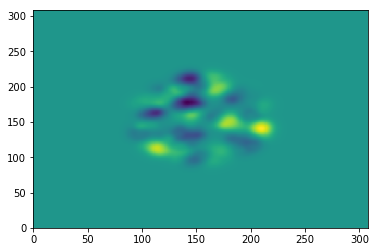

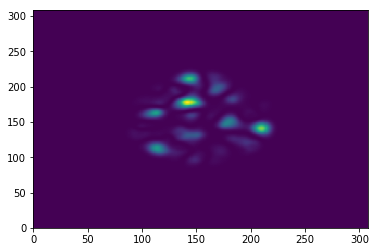

In [36]:
z_ind = 300
plt.pcolormesh(cube_data[:, :, z_ind])
plt.show()
plt.pcolormesh((cube_data[:, :, z_ind]**2))
plt.show()